In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../../')

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.networks import ScoreNet
from sdebridge.utils import *

plt.style.use('ggplot')

In [3]:
def eval_Q(val: jax.Array, time: float, alpha: float, sigma: float) -> jax.Array:
    make_square = lambda Q: Q.reshape((jnp.sqrt(Q.size).astype('int32'), jnp.sqrt(Q.size).astype('int32')))
    k_Q = lambda x: 0.5 * (alpha**2) * (sigma**2) * jnp.pi * jnp.exp(-0.5 * jnp.sum(jnp.square(x), axis=2) / (sigma**2))
    k_Q_q = lambda x1, x2: k_Q(x1.reshape(-1, 2)[:, jnp.newaxis, :] - x2.reshape(-1, 2)[jnp.newaxis, :, :])
    Q = lambda x: make_square(jnp.einsum('ij,kl->ikjl', k_Q_q(x, x), jnp.eye(2)))
    return Q(val)

In [4]:
rng = jax.random.PRNGKey(0)

(1, 101, 16)
(1, 101, 16)
(1, 101, 16)
(1, 101, 16)
(1, 101, 16)


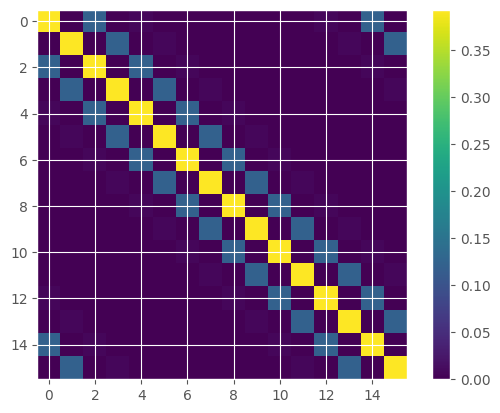

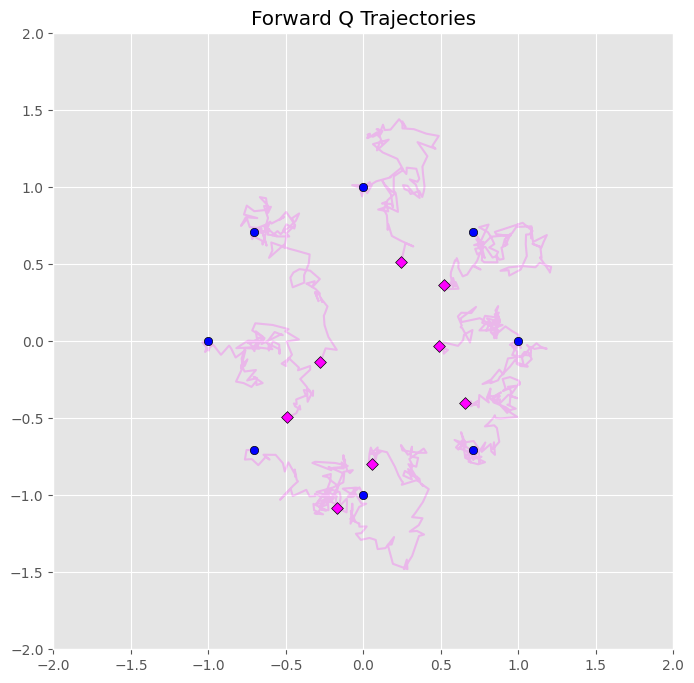

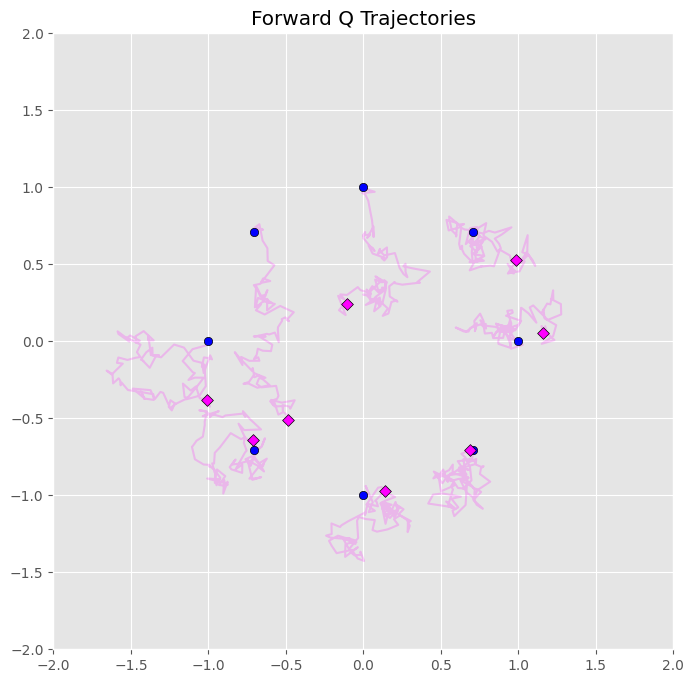

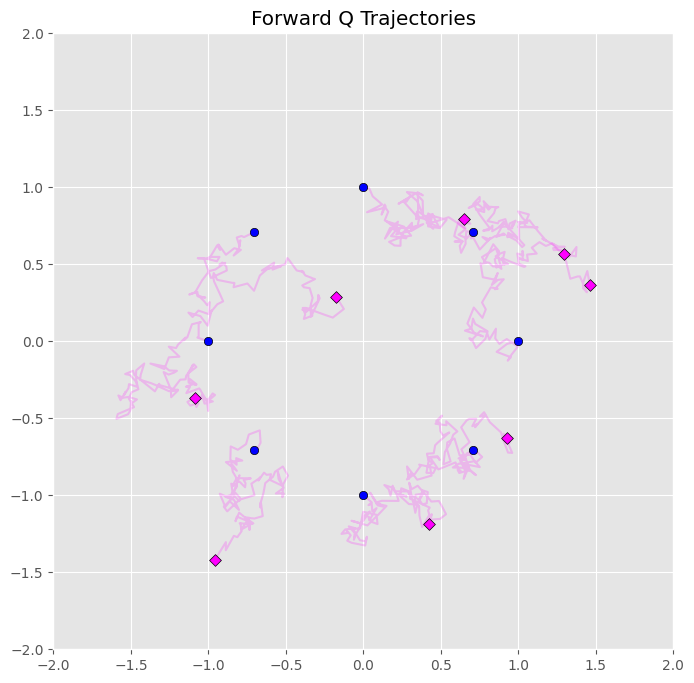

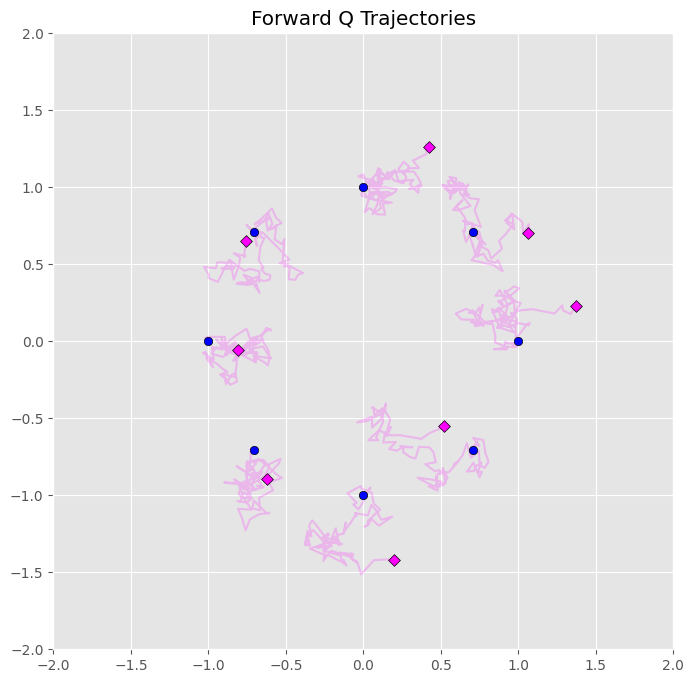

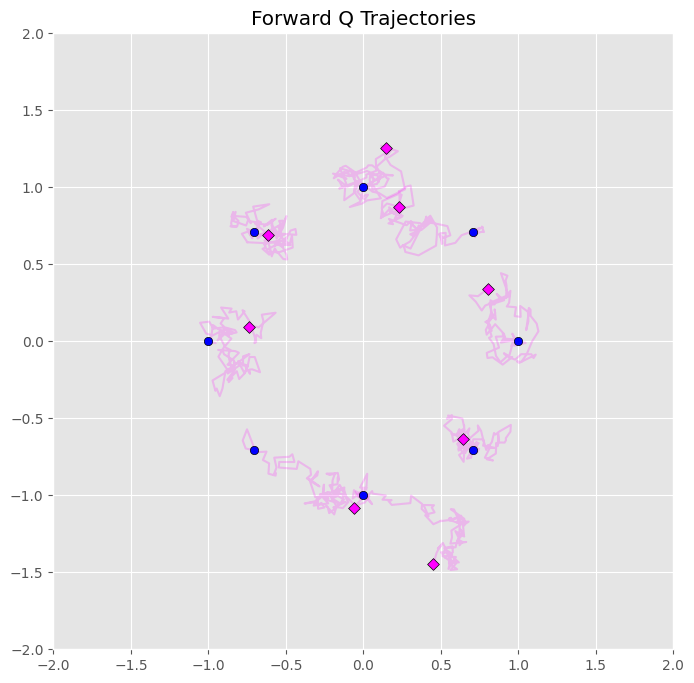

In [9]:
d = 16
alpha = 1.0
sigma = 0.5

circles1 = sample_circle(num_points=d//2, scale=1.0, shifts=jnp.array([0.0, 0.0]))
circles2 = sample_circle(num_points=d//2, scale=1.5, shifts=jnp.array([0.0, 0.0]))
# squares = sample_square(num_points=d//2, scale=1.0, shifts=jnp.array([0.0, 0.0]))
Q = eval_Q(circles1, time=None, alpha=alpha, sigma=sigma)
plt.imshow(Q)
plt.colorbar()

rng, _ = jax.random.split(rng)

# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# ax.scatter(circles.reshape(-1, 2)[:, 0], circles.reshape(-1, 2)[:, 1], color='b')
# ax.scatter(squares.reshape(-1, 2)[:, 0], squares.reshape(-1, 2)[:, 1], color='r')
# print(circles.shape, squares.shape)

def drift(val, time):
    return jnp.zeros(d)

def diffusion(val, time): 
    return Q 

model = DiffusionBridge(
    drift = drift,
    diffusion = diffusion,
    dim=d,
    end_time=1.0,
    num_steps=100,
    rng=rng
)

for i in range(5):
    forward_brownian_motion = model.simulate_forward_process(initial_condition=jnp.tile(circles1, reps=(1, 1)))
    print(forward_brownian_motion["trajectories"].shape)
    plot_trajectories(forward_brownian_motion["trajectories"], title="Forward Q Trajectories")

In [10]:
setup_params = {
    "network": {"out_dim": model.d,
                "time_embedding_dim": 128,
                "embedding_dim": 128,
                "act": 'gelu',
                "encoder_layer_dims": [128, 128],
                "decoder_layer_dims": [128, 128],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 100,
                 "learning_rate": 5e-3}
}
score_p_state = model.learn_p_score(initial_condition=circles1, 
                                    setup_params=setup_params)

Training:   0%|          | 0/50 [00:00<?, ?epoch/s]

(1, 101, 16)


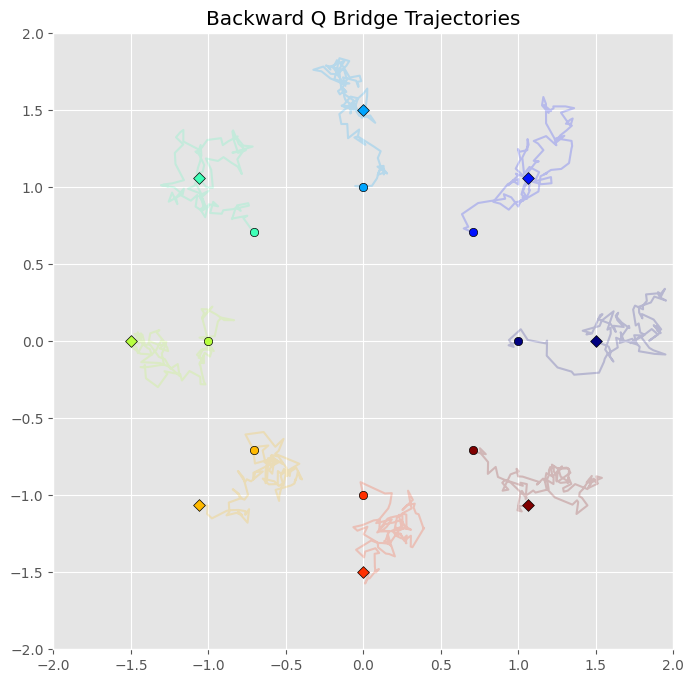

In [11]:
backward_brownian_bridge = model.simulate_backward_bridge(score_p_state=score_p_state, 
                                                          initial_condition=jnp.tile(circles1, reps=(1, 1)), 
                                                          terminal_condition=jnp.tile(circles2, reps=(1, 1)))
print(backward_brownian_bridge["trajectories"].shape)
plot_single_trajectory(backward_brownian_bridge["trajectories"][0], title="Backward Q Bridge Trajectories")

In [8]:
setup_params = {
    "network": {"out_dim": model.d,
                "time_embedding_dim": 128,
                "embedding_dim": 128,
                "act": 'gelu',
                "encoder_layer_dims": [128, 128],
                "decoder_layer_dims": [128, 128],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 100,
                 "learning_rate": 5e-3}
}
score_p_state = model.learn_p_star_score(initial_condition=circles1,
                                         terminal_condition=circles2,
                                         score_p_state=score_p_state,
                                         setup_params=setup_params)

Training:   0%|          | 0/50 [00:00<?, ?epoch/s]

KeyboardInterrupt: 

(1, 51, 16)


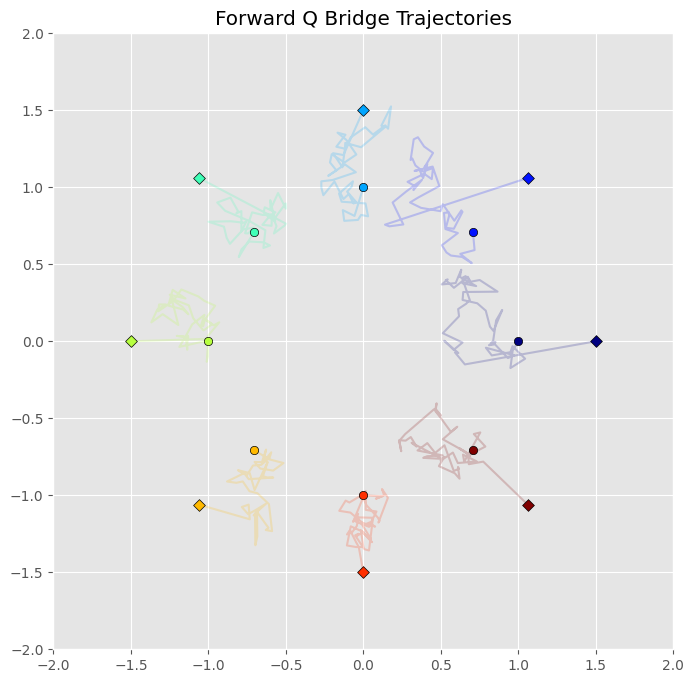

In [37]:
forward_brownian_bridge = model.simulate_forward_bridge(score_p_state=score_p_state,
                                                        score_p_star_state=score_p_state, 
                                                        initial_condition=jnp.tile(circles1, reps=(1, 1)), 
                                                        terminal_condition=jnp.tile(circles2, reps=(1, 1)))
print(forward_brownian_bridge["trajectories"].shape)
plot_single_trajectory(forward_brownian_bridge["trajectories"][0], title="Forward Q Bridge Trajectories")